In [2]:
pip install feature-engine

Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [4]:
df = pd.read_csv('customer_churn_data.csv')

df.shape

(7043, 21)

In [5]:
for col in df.columns:
    print(f"Column Name: {col}")
    print(f"Unique Values: {df[col].unique()}\n")
    

Column Name: customerID
Unique Values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Column Name: gender
Unique Values: ['Female' 'Male']

Column Name: SeniorCitizen
Unique Values: [0 1]

Column Name: Partner
Unique Values: ['Yes' 'No']

Column Name: Dependents
Unique Values: ['No' 'Yes']

Column Name: tenure
Unique Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Column Name: PhoneService
Unique Values: ['No' 'Yes']

Column Name: MultipleLines
Unique Values: ['No phone service' 'No' 'Yes']

Column Name: InternetService
Unique Values: ['DSL' 'Fiber optic' 'No']

Column Name: OnlineSecurity
Unique Values: ['No' 'Yes' 'No internet service']

Column Name: OnlineBackup
Unique Values: ['Yes' 'No' 'No internet service']

Column Name: DeviceProtection
Unique Values: ['No' 

In [6]:
df.columns = map(str.lower, df.columns)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [8]:
df['totalcharges'] = df['totalcharges'].replace(' ', np.nan)
df['totalcharges'] = df['totalcharges'].astype(float)
df['totalcharges'].dtype

dtype('float64')

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
seniorcitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
monthlycharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
totalcharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


In [10]:
df.isnull().sum()

customerid           0
gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [11]:
churn_dist = df['churn'].value_counts(normalize = True).reset_index()
churn_dist.columns = ['Churn', 'distribution']
churn_dist['distribution'] = (churn_dist['distribution'] * 100)
churn_dist

,Churn,distribution
0,No,73.463013
1,Yes,26.536987


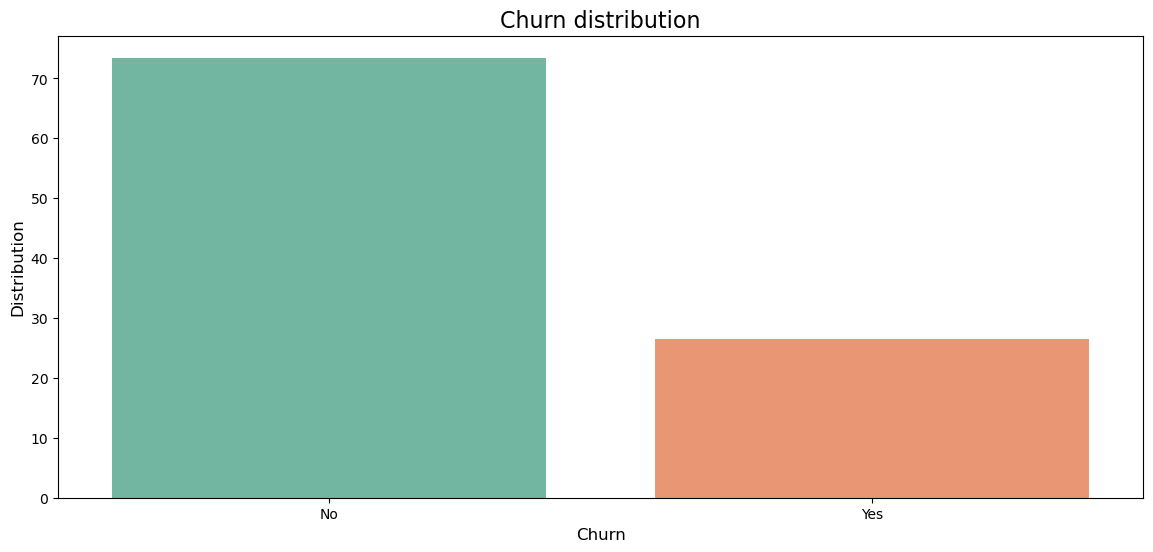

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.barplot(x = 'Churn', y = 'distribution', data = churn_dist, palette='Set2')
ax.set_title("Churn distribution", fontsize = 16)
ax.set_xlabel("Churn", fontsize = 12)
ax.set_ylabel("Distribution", fontsize = 12)
plt.show()

%26 Churn için yüksek bir oran. Bu oranın sebebini öğrenmek çok önemlidir. Box Plot kullanarak gözlem yapalım.

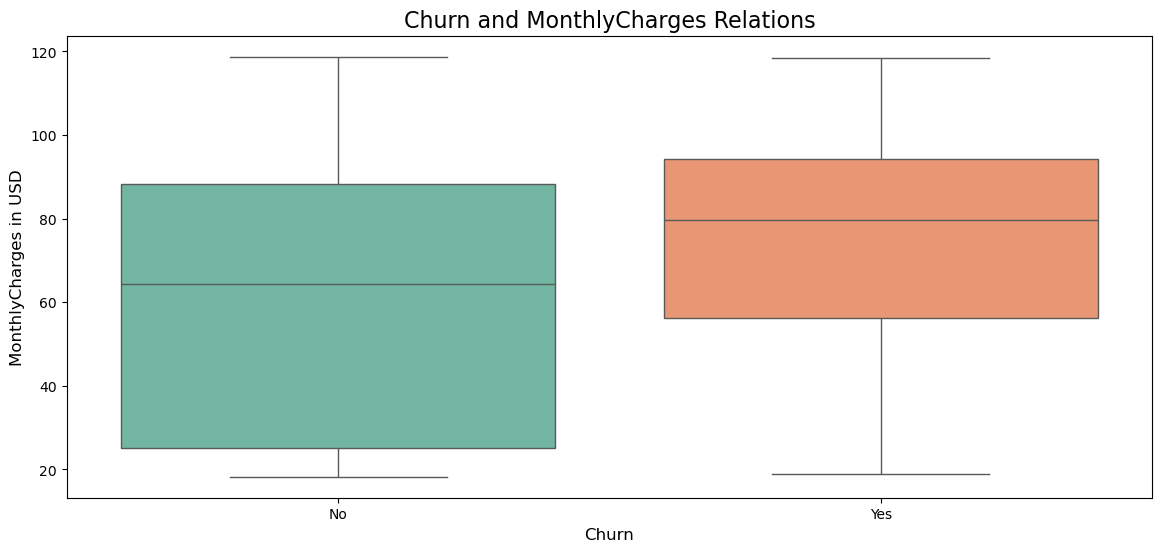

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(x = 'churn', y = 'monthlycharges', palette='Set2', data = df)
ax.set_title("Churn and MonthlyCharges Relations", fontsize = 16)
ax.set_xlabel("Churn", fontsize = 12)
ax.set_ylabel("MonthlyCharges in USD", fontsize = 12)
plt.show()

People who pay higher service fees have a greater tendency to churn

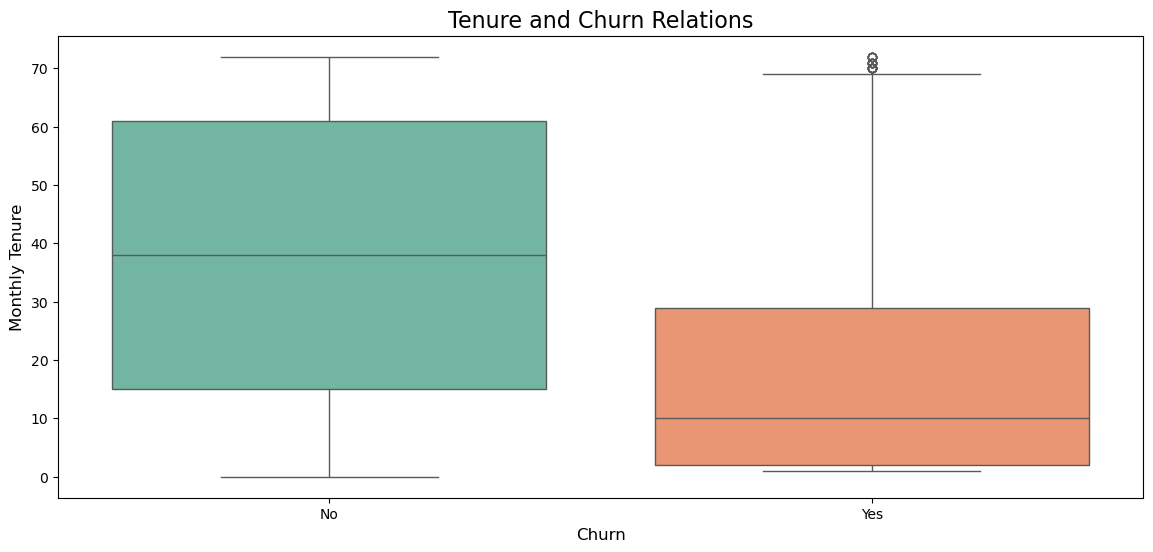

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(x = 'churn', y = 'tenure', palette='Set2', data = df)
ax.set_title("Tenure and Churn Relations", fontsize = 16)
ax.set_xlabel("Churn", fontsize = 12)
ax.set_ylabel("Monthly Tenure", fontsize = 12)
plt.show()

People with a shorter tenure with Telcom have a greater tendency to churn.

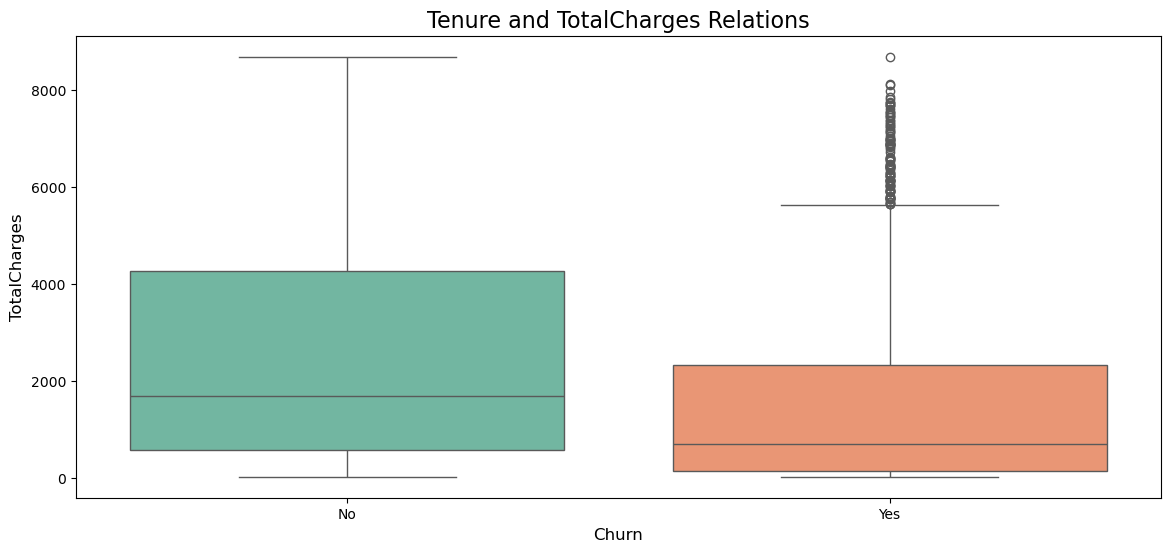

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(x = 'churn', y = 'totalcharges', palette='Set2', data = df)
ax.set_title("Tenure and TotalCharges Relations", fontsize = 16)
ax.set_xlabel("Churn", fontsize = 12)
ax.set_ylabel("TotalCharges", fontsize = 12)
plt.show()

In [19]:
internetservice_churn = df.groupby(['churn', 'internetservice']).agg(frequency = ('churn', 'count')).reset_index()
internetservice_churn

,churn,internetservice,frequency
0,No,DSL,1962
1,No,Fiber optic,1799
2,No,No,1413
3,Yes,DSL,459
4,Yes,Fiber optic,1297
5,Yes,No,113


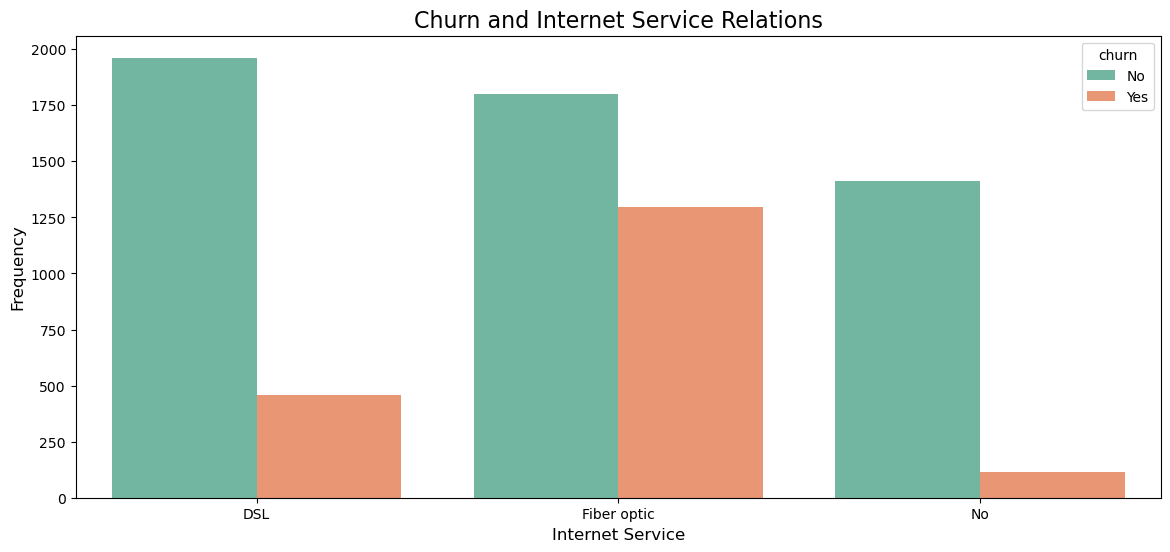

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.barplot(x = 'internetservice', y = 'frequency', hue = 'churn', palette='Set2', data = internetservice_churn)
ax.set_title("Churn and Internet Service Relations", fontsize = 16)
ax.set_xlabel("Internet Service", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)
plt.show()

As we can see customers that using fiber optic internet service are more likely to churn.

In [22]:
contract_churn = df.groupby(['churn', 'contract']).agg(frequency = ('churn', 'count')).reset_index()
contract_churn

,churn,contract,frequency
0,No,Month-to-month,2220
1,No,One year,1307
2,No,Two year,1647
3,Yes,Month-to-month,1655
4,Yes,One year,166
5,Yes,Two year,48


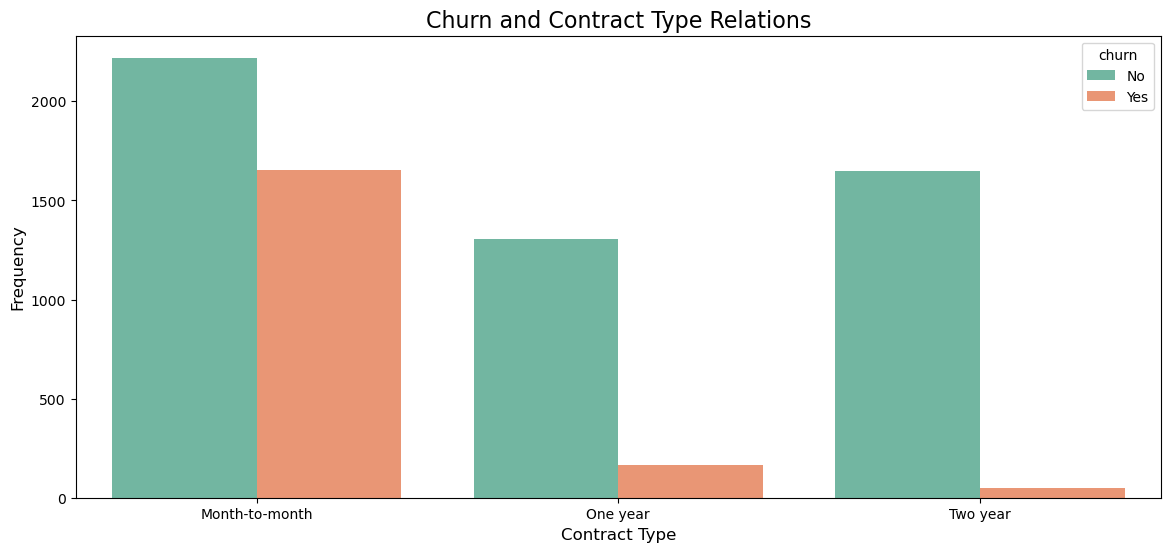

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.barplot(x = 'contract', y = 'frequency', hue = 'churn', palette='Set2', data = contract_churn)
ax.set_title("Churn and Contract Type Relations", fontsize = 16)
ax.set_xlabel("Contract Type", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)
plt.show()

Compared to other types of contracts, there is a greater volume of churn in month-to-month contracts.

In [25]:
paymentmethod_churn = df.groupby(['churn', 'paymentmethod']).agg(frequency = ('churn', 'count')).reset_index()
paymentmethod_churn

,churn,paymentmethod,frequency
0,No,Bank transfer (automatic),1286
1,No,Credit card (automatic),1290
2,No,Electronic check,1294
3,No,Mailed check,1304
4,Yes,Bank transfer (automatic),258
5,Yes,Credit card (automatic),232
6,Yes,Electronic check,1071
7,Yes,Mailed check,308


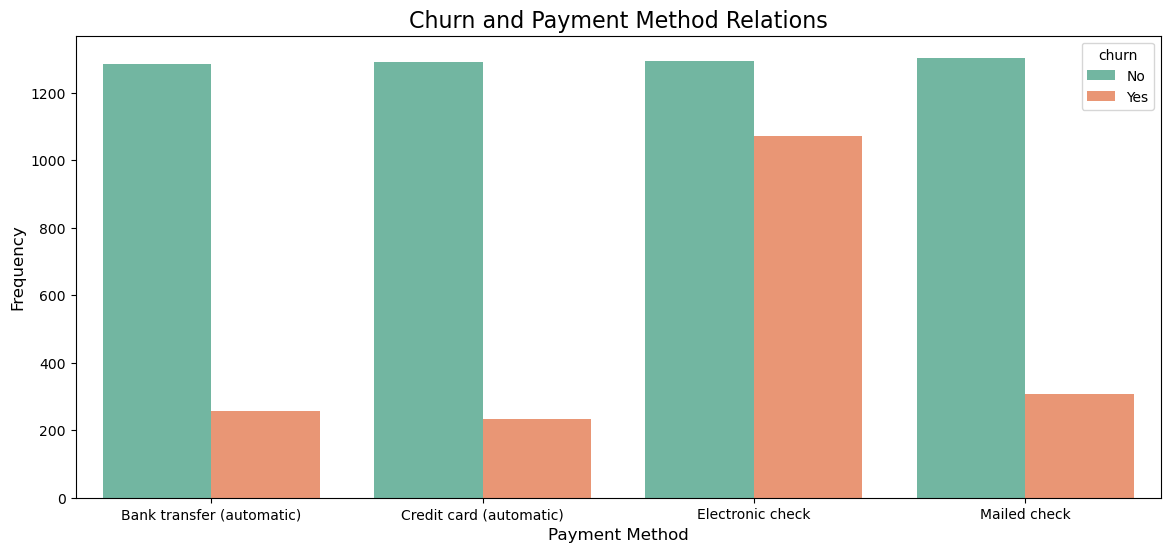

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.barplot(x = 'paymentmethod', y = 'frequency', hue = 'churn', palette='Set2', data = paymentmethod_churn)
ax.set_title("Churn and Payment Method Relations", fontsize = 16)
ax.set_xlabel("Payment Method", fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)
plt.show()

Compared to other types of payment methods, there is a greater volume of churn in electronic check payment method.

In [28]:
labelEncoder = LabelEncoder()
df['churn'] = labelEncoder.fit_transform(df['churn'])

df.head(3)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


In [29]:
X = df.drop(columns = ['customerid', 'churn']) # y = independent variable
y = df['churn'] # y = dependent variable

# Numerical columns
numerical_components = X.dtypes[X.dtypes.apply(lambda x: np.issubdtype(x, np.number))].index.tolist()

# Object columns
object_components = X.dtypes[X.dtypes.apply(lambda x: np.issubdtype(x, np.object_))].index.tolist()

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline([('numeric_input', MeanMedianImputer(imputation_method='median'))])
         , numerical_components),
        ('categorical object', Pipeline([('categorical_input', CategoricalImputer(imputation_method='frequent')),('ohe', OneHotEncoder())])
         , object_components)
    ]
)

preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('numeric_input',
                                                  MeanMedianImputer())]),
                                 ['seniorcitizen', 'tenure', 'monthlycharges',
                                  'totalcharges']),
                                ('categorical object',
                                 Pipeline(steps=[('categorical_input',
                                                  CategoricalImputer(imputation_method='frequent')),
                                                 ('ohe', OneHotEncoder())]),
                                 ['gender', 'partner', 'dependents',
                                  'phoneservice', 'multiplelines',
                                  'internetservice', 'onlinesecurity',
                                  'onlinebackup', 'deviceprotection',
                                  'techsupport', 'streamingtv',
                                  'streamingmovies', 'contract',
                                  'paperlessbilling', 'paymentmethod'])])

One Hot Encoding: Imputation of missing categorical values and conversion of categorical variables into separate columns.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

In [33]:
rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 50],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(rf,
                    param_grid=rf_params,
                    n_jobs=-1,
                    cv = 10,
                    scoring='roc_auc')

rf_tuned = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_grid)
])

rf_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('numeric_input',
                                                                   MeanMedianImputer())]),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('categorical object',
                                                  Pipeline(steps=[('categorical_input',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'partner',
                                                   'depe...
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'deviceprotection',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('model',
                 GridSearchCV(cv=10,
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [10, 20, 50],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [100, 300, 500]},
                              scoring='roc_auc'))])

In [34]:
train_accuracy_rf = accuracy_score(y_train, rf_tuned.predict(X_train))
test_accuracy_rf = accuracy_score(y_test, rf_tuned.predict(X_test))

print("Accuracies")
print(f'Train Accuracy: {train_accuracy_rf}')
print(f'Test Accuracy: {test_accuracy_rf}')

Accuracies
Train Accuracy: 0.854632587859425
Test Accuracy: 0.8034066713981547


In [35]:
knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors': np.arange(1,40),
    'weights': ['uniform', 'distance'],
}

knn_grid = GridSearchCV(knn,
                    param_grid=knn_params,
                    n_jobs=-1,
                    cv = 10,
                    scoring='roc_auc')

knn_tuned = Pipeline([
    ('preprocessor', preprocessor),
    ('model', knn_grid)
])

knn_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('numeric_input',
                                                                   MeanMedianImputer())]),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('categorical object',
                                                  Pipeline(steps=[('categorical_input',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'partner',
                                                   'depe...
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('model',
                 GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
                              n_jobs=-1,
                              param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39]),
                                          'weights': ['uniform', 'distance']},
                              scoring='roc_auc'))])

In [36]:
train_accuracy_knn = accuracy_score(y_train, knn_tuned.predict(X_train))
test_accuracy_knn = accuracy_score(y_test, knn_tuned.predict(X_test))

print("Accuracies")
print(f'Train Accuracy: {train_accuracy_knn}')
print(f'Test Accuracy: {test_accuracy_knn}')

Accuracies
Train Accuracy: 0.7987220447284346
Test Accuracy: 0.7899219304471257


In [37]:
log = LogisticRegression(max_iter = 12000, random_state=42)

log_params = {
    'C': [0.001, 0.01, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg']
}

log_grid = GridSearchCV(log,
                    param_grid=log_params,
                    n_jobs=-1,
                    cv = 10,
                    scoring='roc_auc')

log_tuned = Pipeline([
    ('preprocessor', preprocessor),
    ('model', log_grid)
])

log_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('numeric_input',
                                                                   MeanMedianImputer())]),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('categorical object',
                                                  Pipeline(steps=[('categorical_input',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'partner',
                                                   'depe...
                                                   'onlinebackup',
                                                   'deviceprotection',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('model',
                 GridSearchCV(cv=10,
                              estimator=LogisticRegression(max_iter=12000,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid={'C': [0.001, 0.01, 1, 10, 100],
                                          'penalty': ['l1', 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg']},
                              scoring='roc_auc'))])

In [38]:
train_accuracy_log = accuracy_score(y_train, log_tuned.predict(X_train))
test_accuracy_log = accuracy_score(y_test, log_tuned.predict(X_test))

print("Accuracies")
print(f'Train Accuracy: {train_accuracy_log}')
print(f'Test Accuracy: {test_accuracy_log}')

Accuracies
Train Accuracy: 0.8059992900248492
Test Accuracy: 0.8048261178140526


In [39]:
r_probs = [0 for _ in range(len(y_test))]
rf_probs = rf_tuned.predict_proba(X_test)
knn_probs = knn_tuned.predict_proba(X_test)
log_probs = log_tuned.predict_proba(X_test)

rf_probs = rf_probs[:, 1]
knn_probs = knn_probs[:, 1]
log_probs = log_probs[:, 1]

Let's calculate the AUROC which is area under the roc curve.

In [41]:
r_auc = roc_auc_score(y_test, r_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
log_auc = roc_auc_score(y_test, log_probs)

Now Let's calculate ROC Curves. Remember that fpr is false positive rate and tpr is true positive rate.

In [43]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs) 
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs) 
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs) 
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs) 


In [44]:
print('Random (chance) prediction: AUROC = %.4f' % (r_auc))
print('Random Forest: AUROC = %.4f' % (rf_auc))
print('K-Nearest Neighbors: AUROC = %.4f' % (knn_auc))
print('Logistic Regression: AUROC = %.4f' % (log_auc))

Random (chance) prediction: AUROC = 0.5000
Random Forest: AUROC = 0.8409
K-Nearest Neighbors: AUROC = 0.8005
Logistic Regression: AUROC = 0.8411


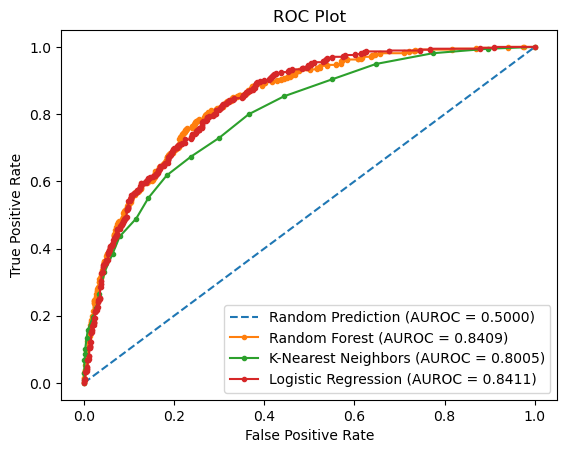

In [45]:
plt.plot(r_fpr, r_tpr, linestyle = '--', label = 'Random Prediction (AUROC = %0.4f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker = '.', label = 'Random Forest (AUROC = %0.4f)' % rf_auc)
plt.plot(knn_fpr, knn_tpr, marker = '.', label = 'K-Nearest Neighbors (AUROC = %0.4f)' % knn_auc)
plt.plot(log_fpr, log_tpr, marker = '.', label = 'Logistic Regression (AUROC = %0.4f)' % log_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [59]:
input_data = pd.DataFrame([['Female', 1, 'Yes', 'Yes', 30, 'No', 'No phone service', 'Fiber optic', 'Yes', 'No', 'No'
                            , 'Yes', 'No', 'No', 'Mont-to-month', 'Yes', 'Electronic Check', 55.33, 3649.932]]
                          
                          , columns=['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines'
                          , 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv'
                                     , 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges'
                                     , 'totalcharges'])

prediction = log_tuned.predict(input_data)[0]

if prediction == 0:
    churn_status = "Customer will not Churn"
elif prediction == 1:
    churn_status = "Customer will Churn"

print(churn_status)

Customer will not Churn
